In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

In [3]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [4]:
urls = search_images('man with beard photos', max_images=1)
urls[0]

Searching for 'man with beard photos'


'https://menshaircutstyle.com/wp-content/uploads/beard-man-50.jpg'

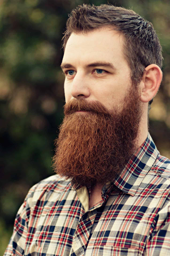

In [5]:
from fastdownload import download_url
dest = 'man with beard.jpg'
download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'man without beard photos'


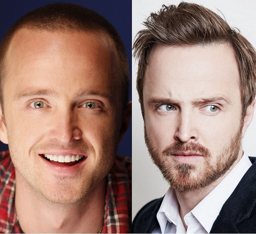

In [6]:
download_url(search_images('man without beard photos', max_images=1)[0], 'man without beard.jpg', show_progress=False)
Image.open('man without beard.jpg').to_thumb(256,256)

Searching for 'grandfather photos'


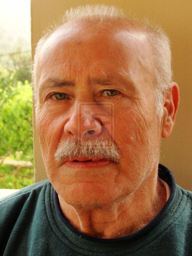

In [65]:
download_url(search_images('grandfather photos', max_images=1)[0], 'grandfather.jpg', show_progress=False)
Image.open('grandfather.jpg').to_thumb(256,256)

Searching for 'child photos'


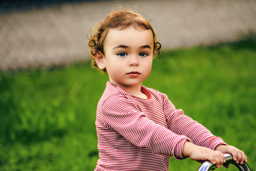

In [8]:
download_url(search_images('child photos', max_images=1)[0], 'child.jpg', show_progress=False)
Image.open('child.jpg').to_thumb(256,256)

In [9]:
searches = 'man with beard','man without beard', 'grandfather', 'child' 
path = Path('multiclass')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'man with beard photo'
Searching for 'man without beard photo'
Searching for 'woman photo'
Searching for 'child photo'


In [68]:
dest = (path/'grandfather')
dest.mkdir(exist_ok=True, parents=True)
download_images(dest, urls=search_images(f'grandfather photo'))
resize_images(path/'grandfather', max_size=400, dest=path/'grandfather')

Searching for 'grandfather photo'


In [69]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

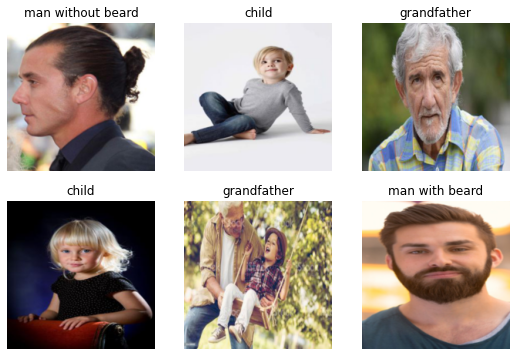

In [70]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [71]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

E:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
E:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.610892,3.230994,0.684211,00:07


epoch,train_loss,valid_loss,error_rate,time
0,2.355103,2.055722,0.578947,00:08
1,1.853064,1.128924,0.473684,00:08
2,1.427272,0.787745,0.421053,00:09


In [48]:
is_man_with_beard,_,probs = learn.predict(PILImage.create('man with beard.jpg'))
print(f"This is a: {is_man_with_beard}.")
probs
#print(f"Probability it's a man with beard: {probs[0]:.4f}")

This is a: man with beard.


TensorBase([0.0096, 0.8288, 0.1599, 0.0017])

In [72]:
classes = learn.dls.vocab

In [73]:
def top_5_preds(preds):    
    preds_s = preds.argsort(descending=True)
    preds_s=preds_s[:4]    
    return preds_s

In [74]:
def top_4_pred_labels(preds, classes):
    top_5 = top_5_preds(preds)
    labels = []
    confidence=[]
    for i in top_5:
        x=classes[i]
        p=preds[i]
        labels.append(x)
        confidence.append(p)
    return labels, confidence

In [75]:
top_5_predictions,top_5_confidence=top_4_pred_labels(probs,classes) 

In [76]:
top_5_confidence

[TensorBase(0.8288),
 TensorBase(0.1599),
 TensorBase(0.0096),
 TensorBase(0.0017)]

In [77]:
top_5_predictions

['grandfather', 'man with beard', 'child', 'man without beard']

In [80]:
is_man_without_beard,_,probs = learn.predict(PILImage.create('man without beard.jpg'))
print(f"This is a: {is_man_without_beard}.")
top_5_predictions,top_5_confidence=top_4_pred_labels(probs,classes) 
top_5_confidence

This is a: man without beard.


[TensorBase(0.9962),
 TensorBase(0.0020),
 TensorBase(0.0012),
 TensorBase(0.0006)]

In [81]:
is_child,_,probs = learn.predict(PILImage.create('child.jpg'))
print(f"This is a: {is_child}.")
top_5_predictions,top_5_confidence=top_4_pred_labels(probs,classes) 
top_5_confidence

This is a: child.


[TensorBase(0.9019),
 TensorBase(0.0933),
 TensorBase(0.0036),
 TensorBase(0.0012)]

In [82]:
is_grandfather,_,probs = learn.predict(PILImage.create('grandfather.jpg'))
print(f"This is a: {is_grandfather}.")
top_5_predictions,top_5_confidence=top_4_pred_labels(probs,classes) 
top_5_confidence

This is a: grandfather.


[TensorBase(0.5632),
 TensorBase(0.3772),
 TensorBase(0.0443),
 TensorBase(0.0153)]

In [83]:
top_5_predictions

['grandfather', 'man with beard', 'man without beard', 'child']